In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
sys.path.append("../src")
import utils as u


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
from scipy.optimize import root_scalar


class PeelingModel:
    def __init__(self, params):
        self.params = params
        self.G0 = params["G0"]
        self.G1 = params["G1"]
        self.L0 = params["L0"]
        self.L1 = params["L1"]
        self.N = params["N"]
        self.P = self.L0 + self.L1
        self.G_c = self._compile_toughness_function()

    def _compile_toughness_function(self):
        def G_c(x):
            mod_x = np.mod(x, self.P)
            return np.where(mod_x < self.L0, self.G0, self.G1)

        return np.vectorize(G_c)

    def get_right_Gc(self, l, tol=1e-3):
        mod_l = np.mod(l + tol, self.P)
        return self.G0 if mod_l < self.L0 else self.G1

    def energy(self, l, t,):
        P = self.P
        L0 = self.L0
        L1 = self.L1
        G0 = self.G0
        G1 = self.G1
        
        k = np.floor(l / P)
        rem = l - k * P
        rem_G0 = np.minimum(rem, L0)
        rem_G1 = np.maximum(0, rem - L0)
        toughness_integral = (
            k * (G0 * L0 + G1 * L1) + G0 * rem_G0 + G1 * rem_G1
        )
        return -self.N * t**2 / (2 * l) + toughness_integral

    def dE(self, l, t, tol=1e-3):
        return self.N * t**2 / (2 * l**2) + self.G_c(l)

    def d2E(self, l, t, tol=1e-4):
        P = self.P
        
        smooth_curvature = -self.N * t**2 / (l**3)
        singular_curvature = 0.0
        k = np.floor(l / P)
        rem = l - k * P
        G0, G1 = self.G0, self.G1
        
        if np.isclose(rem, self.L0, atol=tol):
            # print("singular curvature +")
            singular_curvature += G1 - G0
        elif np.isclose(rem, self.L0 + self.L1, atol=tol):
            # print("singular curvature -")
            singular_curvature += G0 - G1
        else:
            singular_curvature = 0.0

        return smooth_curvature + singular_curvature

    def integrate_fast_flow(self, l0, t, s_max=5.0, dt=0.01):
        l_vals = [l0]
        s_vals = [0.0]
        diss = 0.0
        drives = [-self.dE(l0, t)]
        l = l0
        s = 0.0

        while s < s_max:
            # drive = fast_flow_rhs(l, t)
            drive = max(0.0, -self.dE(l, t))
            if drive <= 1e-6:
                break  # stability reached

            dl = drive * dt
            l += dl
            s += dt
            diss += drive**2 * dt

            l_vals.append(l)
            s_vals.append(s)
            drives.append(drive)

        return np.array(s_vals), np.array(l_vals), diss, drives

    # Define a function that solves the energy conservation equation
    def solve_energy_conservation_jump(
        self, 
        L, T, L_max=5.0, dx=1e-3, tol=1e-3, num_subintervals=5
        ):
        """
        Solves the equation:
            -N T^2 / (2*L) = -N T^2 / (2*L_+) + ∫_{L}^{L_+} G_c(x) dx
        for L_+ > L given an instability at (L, T).

        Parameters:
            L : float       -- current (unstable) crack length
            T : float       -- fixed loading time
            L_max : float   -- upper bound for crack search
            dx : float      -- step size for numerical integration
            tol : float     -- tolerance for root solver

        Returns:
            L_plus : float  -- solution of the energy conservation equation
        """
        G_c_func = self.G_c
        # LHS is fixed
        N_val = self.N
        lhs_val = -N_val * T**2 / (2 * L)

        # RHS = -N T^2 / 2* L_+ + ∫ G_c from L to L_+
        def rhs(L_plus):
            xs = np.arange(L, L_plus, dx)
            gc_vals = G_c_func(xs)
            integral = np.sum(gc_vals) * dx
            return -N_val * T**2 / (2 * L_plus) + integral

        # Residual
        def residual(L_plus):
            return rhs(L_plus) - lhs_val

        # Divide into subintervals
        brackets = np.linspace(L + tol, L_max, num_subintervals + 1)

        for i in range(num_subintervals):
            a, b = brackets[i], brackets[i + 1]
            try:
                fa, fb = residual(a), residual(b)
                # print(f"Bracket ({a:.4f}, {b:.4f}) with fa={fa:.4f}, fb={fb:.4f}")
                if fa * fb < 0:
                    # print(f"Trying subinterval ({a:.4f}, {b:.4f})")
                    sol = root_scalar(residual, bracket=(a, b), method="brentq", xtol=tol)
                    if sol.converged:
                        return sol.root
            except Exception as e:
                print(f"  Error in subinterval ({a:.4f}, {b:.4f}): {e}")
                continue


    def run_variational_flow(
        self,
        t_grid,
        l_0,
    ):
        get_right_Gc = self.get_right_Gc
        energy = self.energy
        dE = self.dE
        d2E = self.d2E
        N_val = self.N
        jump = self.integrate_fast_flow

        l_path = np.zeros_like(t_grid)
        dissipation_path = np.zeros_like(t_grid)
        drive_path = np.zeros_like(t_grid)
        curvature_path = np.zeros_like(t_grid)

        l_current = l_0
        dissipation_current = 0.0
        delta = 1e-3

        for i, t in enumerate(t_grid):
            if i == 0:
                l_path[i] = l_0
                continue

            _local_Gc = get_right_Gc(l_path[i - 1], tol=delta)
            slope = np.sqrt(-N_val / (2 * _local_Gc))
            l_guess = slope * t
            l_current = max(l_guess, l_path[i - 1])
            l_path[i] = l_current

            drive = dE(l_current, t, tol=delta)
            curvature = d2E(l_current, t, tol=1e-2)

            drive_path[i] = drive
            curvature_path[i] = curvature

            if drive < -1e-10:
                _s, _l, diss, drives = jump(l_path[i], t, s_max=5.0, dt=0.01)
                dissipation_current += diss
                l_path[i] = _l[-1]

            dissipation_path[i] = dissipation_current

        E_total = [energy(l, t) for l, t in zip(l_path, t_grid)]

        return {
            "l_path": l_path,
            "t_grid": t_grid,
            "E_path": E_total,
            "dissipation_path": dissipation_path,
            "drive_path": drive_path,
            "curvature_path": curvature_path,
        }


    def run_energy_conserving(
        self,
        t_grid,
        l_0,
    ):
        jump=self.solve_energy_conservation_jump
        get_right_Gc = self.get_right_Gc
        energy = self.energy
        dE = self.dE
        d2E = self.d2E
        N_val = self.N
        
        l_path = np.zeros_like(t_grid)
        drive_path = np.zeros_like(t_grid)
        curvature_path = np.zeros_like(t_grid)
        delta = 1e-3

        for i, t in enumerate(t_grid):
            if i == 0:
                l_path[i] = l_0
                continue

            _local_Gc = get_right_Gc(l_path[i - 1], tol=delta)
            slope = np.sqrt(-N_val / (2 * _local_Gc))
            l_guess = slope * t
            l_current = max(l_guess, l_path[i - 1])
            l_path[i] = l_current

            drive = dE(l_current, t, tol=delta)
            curvature = d2E(l_current, t, tol=1e-2)

            drive_path[i] = drive
            curvature_path[i] = curvature

            if drive < -1e-10:
                L_val = l_current
                T_val = t
                L_plus = jump(
                    L=L_val,
                    T=T_val,
                    L_max=L_val + 3,
                    tol=1e-2,
                    num_subintervals=5,
                )
                l_path[i] = L_plus

        E_total = [energy(l, t) for l, t in zip(l_path, t_grid)]

        return {
            "l_path": l_path,
            "t_grid": t_grid,
            "E_path": E_total,
            "dissipation_path": np.zeros_like(t_grid),  # Optional: fill if needed
            "drive_path": drive_path,
            "curvature_path": curvature_path,
        }


    def run_global_minimizer(
        self,
        t_grid,
        l_0,
        l_max=5.0,
        dl=1e-3,
        delta=1e-2,
        **kwargs,
    ):
        energy = self.energy
        dE = self.dE
        d2E = self.d2E
        # get_right_Gc = self.get_right_Gc,
        
        l_path = np.full_like(t_grid, np.nan)
        l_prev = l_0
        drive_path = np.zeros_like(t_grid)
        curvature_path = np.zeros_like(t_grid)

        for i, t in enumerate(t_grid):
            if i == 0:
                l_path[i] = l_0
                continue

            # Candidate search range
            l_horiz = l_prev + 5 if l_prev + 5 < l_max else l_max
            # l_horiz = l_max
            l_candidates = np.arange(l_prev, l_horiz, dl)
            energies = [energy(l, t) for l in l_candidates]
            l_current = l_candidates[np.argmin(energies)]

            l_path[i] = l_current
            l_prev = l_current

            drive = dE(l_current, t, tol=delta)
            curvature = d2E(l_current, t, tol=1e-2)

            drive_path[i] = drive
            curvature_path[i] = curvature

        E_total = [energy(l, t) for l, t in zip(l_path, t_grid)]

        return {
            "l_path": l_path,
            "t_grid": t_grid,
            "E_path": E_total,
            "dissipation_path": np.zeros_like(t_grid),  # Optional: fill if needed
            "drive_path": drive_path,
            "curvature_path": curvature_path,
        }


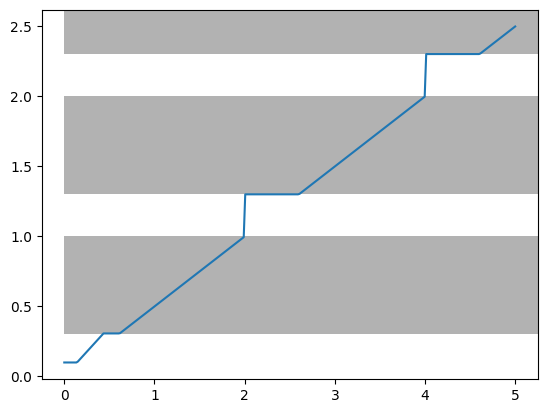

In [3]:
params = {"G0": 1.0, "G1": 2.0, "L0": 0.3, "L1": 0.7, "N": -1.0}

model = PeelingModel(params)
t_grid = np.linspace(0.0, 5.0, 300)
data = model.run_variational_flow(t_grid, l_0=0.1)
# data = model.run_global_minimizer(t_grid, l_0=0.1)
# data = model.run_energy_conserving(t_grid, l_0=0.1)

plt.plot(t_grid, data["l_path"])

u.add_toughness_background(
    ax=plt.gca(),
    # x_max = max(data['l_path']),
    x_max=10,
    G0=model.G0,
    G1=model.G1,
    L0=model.L0,
    L1=model.L1,
    orientation="horizontal",
)


In [30]:
E_total = np.array(data["E_path"])
# Example: Normalize total energy to [0, 1]
normalized_energy = (E_total - np.min(E_total)) / (np.max(E_total) - np.min(E_total))
np.savetxt("../sound/energy_modulation.txt", normalized_energy, fmt="%.4f")

with open("../sound/energy_modulation_hs.txt", "w") as f:
    values = ", ".join(f"{v:.4f}" for v in normalized_energy)
    f.write(f"[{values}]")

In [40]:
model_evos = ["run_variational_flow", "run_energy_conserving", "run_global_minimizer"]
model_labels = ["Flow", "Conserve", "Minimiser"]

for label, method in zip(model_labels, model_evos):
    run_method = getattr(model, method)
    print(run_method)


<bound method PeelingModel.run_variational_flow of <__main__.PeelingModel object at 0x1167f1460>>
<bound method PeelingModel.run_energy_conserving of <__main__.PeelingModel object at 0x1167f1460>>
<bound method PeelingModel.run_global_minimizer of <__main__.PeelingModel object at 0x1167f1460>>


In [32]:
data.keys()

dict_keys(['l_path', 't_grid', 'E_path', 'dissipation_path', 'drive_path', 'curvature_path'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact


# Dummy model computation (replace with your actual runner)
def run_evolutions_for_params(
    G0, gamma, rho, method="run_variational_flow", T_max=3.0, timesteps=200
):
    G1 = gamma * G0
    L0 = rho
    L1 = 1-rho
    # N = -1.0
    l_0 = 0.1

    params = {"G0": G0, "G1": G1, "L0": L0, "L1": L1, "N": -1.0}

    t_grid = np.linspace(0, T_max, timesteps)
    model = PeelingModel(params)
    run_method = getattr(model, method)
    data = run_method(t_grid, l_0=l_0)

    return data, params


@interact(
    gamma=widgets.FloatSlider(
        value=2.0, min=1.0, max=5.0, step=0.1, description="γ = G₁/G₀"
    ),
    rho=widgets.FloatSlider(
        value=.5, min=0.05, max=1.0, step=0.05, description="ρ = L₁/L₀"
    ),
)

def update_plot(gamma, rho):
    G0 = 1.
    
    data, params = run_evolutions_for_params(
        G0, gamma, rho, method="run_variational_flow"
    )
    t_grid = data["t_grid"]
    l_path = data["l_path"]
    p = params
    # print(data)
    runtime = np.nan
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(t_grid, l_path, label=f"Variational Flow", lw=7)
    u.add_toughness_background(ax, max(t_grid), p["G0"], p["G1"], p["L0"], p["L1"], alpha=.1, orientation="horizontal")
    ax.set_xlabel("Time $t$")
    ax.set_ylabel("Crack length $l(t)$")
    ax.set_title(f"Crack Evolution with $\\gamma = {gamma:.1f}$, $\\rho = {rho:.1f}$")
    
    ax.plot(
        t_grid,
        [np.sqrt(-p["N"] / (2 * p['G0'])) * t for t in t_grid],
        color="gray",
        linestyle="-",
        label="$l_0(t)$",
        alpha=0.5,
    )
    # ax[0].set_xlim(0, 7)
    ax.plot(
        t_grid,
        [np.sqrt(-p["N"] / (2 * p['G1'])) * t for t in t_grid],
        color="gray",
        linestyle="--",
        label="$l_1(t)$",
        alpha=0.5,
    )
    

    data, params = run_evolutions_for_params(
        G0, gamma, rho, method="run_energy_conserving"
    )
    t_grid = data["t_grid"]
    l_path = data["l_path"]
    ax.plot(t_grid, l_path, label=f"Energy conserving", lw=3)

    data, params = run_evolutions_for_params(
        G0, gamma, rho, method="run_global_minimizer"
    )
    t_grid = data["t_grid"]
    l_path = data["l_path"]
    ax.plot(t_grid, l_path, label=f"Global minimum", lw=3)

    plt.tight_layout()
    ax.legend()


interactive(children=(FloatSlider(value=2.0, description='γ = G₁/G₀', max=5.0, min=1.0), FloatSlider(value=0.5…

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy as sp
from scipy.optimize import root_scalar
import ipywidgets as widgets
from ipywidgets import interact
from visuals import visuals
from matplotlib.patches import Rectangle


# Crack Propagation in Periodic Heterogeneous Substrates

This notebook investigates crack evolution in a thin film adhered to a rigid substrate with periodically varying fracture toughness. The film is perfectly flexible, inextensible, and initially bonded flat. Crack propagation is driven by a vertical displacement imposed at the boundary, coupled with constant horizontal tension.

We analyse the scenario where the substrate toughness alternates periodically between two values, $G_0$ and $G_1\geq G_0$, representing weak and strong adhesion zones, respectively. Our main goal is to explore how three different crack evolution criteria (nameyly, **variational flow**, **energy conservation**, and **global minimality**) affect the resulting crack evolution.

## Problem Setting

The total potential energy $E(\ell,t)$ of a film peeled up to a crack length $l$ at time $t$ is expressed as:

$$
E(l,t) = \frac{N t^2}{2l} + \int_0^l G_c(x)\,dx,
$$

with the periodic toughness distribution given by:

$$
G_c(x) =
\begin{cases}
G_0 & \text{if }\,\mathrm{mod}(x,L_0+L_1)<L_0,\\
G_1 & \text{otherwise.}
\end{cases}
$$

The crack evolution must fulfill the variational inequality conditions:

- Non-decreasing crack length $l(t)$.
- First-order stability conditions ensuring criticality.
- Second-order stability (positive second derivative of the energy) except at discrete jumps.
- Energy balance across jump transitions.

The numerical simulations conducted here solve this formulation explicitly, allowing comparison between different evolution criteria.

## Numerical Approach and Comparison of Criteria

We numerically solve the problem under three distinct crack growth criteria:

- **Variational Flow**: Local stability drives incremental crack growth, with jumps arising from instabilities resolved via gradient descent on energy.
- **Energy Conservation**: Crack propagation follows a global energy continuity principle, often allowing large jumps that bypass local toughness interfaces.
- **Global Minimality**: At each increment, the globally minimal energy state is selected, effectively homogenizing the toughness variations.

Each criterion reveals distinctive qualitative and quantitative characteristics, providing insights into crack propagation in heterogeneous materials.

In [7]:
# x = sp.symbols("x")

# def set_model_params(params):
#     global G0_val, G1_val, L0_val, L1_val, N_val, _G_c, P

#     G0_val = params["G0"]
#     G1_val = params["G1"]
#     L0_val = params["L0"]
#     L1_val = params["L1"]
#     N_val = params["N"]

#     # Define piecewise toughness function
#     P = L0_val + L1_val

#     def G_c(x):
#         mod_x = np.mod(x, P)
#         return np.where(mod_x < L0_val, G0_val, G1_val)

#     _G_c = np.vectorize(G_c)

#     P = L0_val + L1_val

params = {"G0": 1, "G1": 2, "L0": 0.3, "L1": 0.7, "N": -1, "t": 1.0}

u.set_model_params(params)

# G_c_expr = sp.Piecewise(
#     (G0_val, (x % P) < L0_val),
#     (G1_val, True),  # G1 applies for the rest of the period
# )
# _G_c = sp.lambdify(x, G_c_expr, modules="numpy")

G_c_expr = u.G_c_expr
_G_c = u._G_c


In [73]:
t_val = 0

def get_right_Gc(l, tol=1e-3):
    mod_l = np.mod(l + tol, P)
    return G0_val if mod_l < L0_val else G1_val

# Define pointwise energy, gradient, and curvature (first and second derivatives)
def energy_pointwise(l, t=t_val):
    k = np.floor(l / P)
    rem = l - k * P
    rem_G0 = np.minimum(rem, L0_val)
    rem_G1 = np.maximum(0, rem - L0_val)
    toughness_integral = (
        k * (G0_val * L0_val + G1_val * L1_val) + G0_val * rem_G0 + G1_val * rem_G1
    )
    return -N_val * t**2 / (2 * l) + toughness_integral


def dE_pointwise(l, t=t_val, tol=1e-3):
    mod_l = np.mod(l + tol, P)
    G = G0_val if mod_l < L0_val else G1_val
    # print(f"mod_l: {mod_l}, G: {G}, {mod_l+tol} < {L0_val}")
    return N_val * t**2 / (2 * l**2) + G


def d2E_pointwise(l, t=t_val, tol=1e-4):
    smooth_curvature = -N_val * t**2 / (l**3)
    singular_curvature = 0.0
    k = np.floor(l / P)
    rem = l - k * P

    if np.isclose(rem, L0_val, atol=tol):
        # print("singular curvature +")
        singular_curvature += G1_val - G0_val
    elif np.isclose(rem, L0_val + L1_val, atol=tol):
        # print("singular curvature -")
        singular_curvature += G0_val - G1_val
    else:
        singular_curvature = 0.0

    return smooth_curvature + singular_curvature


def l_vs_t(l_path, t_grid, t):
    # return interpolated value of l_path at time t
    if t < t_grid[0] or t > t_grid[-1]:
        raise ValueError("t is out of bounds of the time grid")
    return np.interp(t, t_grid, l_path)


In [74]:

def run_evo_with_params(
    params,
    evo,
    kwargs={},
):
    assert params["L0"] + params["L1"] > 0, "L0 and L1 must be positive"
    assert params["L0"] + params["L1"] == 1, "P:=L0 + L1 must be equal to 1"
    set_model_params(params)

    # print("Running evolution with parameters")
    t_grid = np.linspace(params["T_min"], params["T_max"], params["timesteps"])
    l_0 = params["l_0"]

    data = evo(
        t_grid=t_grid,
        l_0=params["l_0"],
        get_right_Gc=get_right_Gc,
        energy_pointwise=energy_pointwise,
        dE_pointwise=dE_pointwise,
        d2E_pointwise=d2E_pointwise,
        **kwargs,
        # jump=integrate_fast_flow,
    )
    data["params"] = params
    return data


def compute_metrics(data, label=None, tol=1e-3):
    l_path = data["l_path"]
    t_grid = data["t_grid"]
    diss = data.get("dissipation_path", np.zeros_like(t_grid))

    # Compute jump sizes
    dl = np.diff(l_path)
    jump_sizes = dl[dl > tol]
    return {
        "label": label,
        "final_length": l_path[-1],
        "max_jump": np.max(jump_sizes) if len(jump_sizes) else 0.0,
        "n_jumps": len(jump_sizes),
        "jump_sizes": jump_sizes,
        "total_dissipation": diss[-1],
        "avg_jump": np.mean(jump_sizes) if len(jump_sizes) else 0.0,
        "var_jump": np.var(jump_sizes) if len(jump_sizes) else 0.0,
    }


def compute_energy(l_array, t_val=t_val):
    k = np.floor(l_array / P)
    rem = l_array - k * P
    rem_G0 = np.minimum(rem, L0_val)
    rem_G1 = np.maximum(0, rem - L0_val)
    toughness_integral = (
        k * (G0_val * L0_val + G1_val * L1_val) + G0_val * rem_G0 + G1_val * rem_G1
    )
    energy = -N_val * t_val**2 / (2 * l_array) + toughness_integral
    return energy


def compute_surface_energy(l_array):
    k = np.floor(l_array / P)
    rem = l_array - k * P
    rem_G0 = np.minimum(rem, L0_val)
    rem_G1 = np.maximum(0, rem - L0_val)
    surface_energy = (
        k * (G0_val * L0_val + G1_val * L1_val) + G0_val * rem_G0 + G1_val * rem_G1
    )
    return surface_energy


def compute_energy_derivative(l_array, side="right", t_val=t_val):
    dE_dl = -N_val * t_val**2 / (2 * l_array**2) + compute_surface_energy_derivative(
        l_array, side
    )

    return dE_dl


def compute_surface_energy_derivative(l_array, side="right"):
    k = np.floor(l_array / P)
    rem = np.mod(l_array, P)
    if side == "left":
        dE_dl = np.where(rem <= L0_val, G0_val, G1_val)
    elif side == "right":
        dE_dl = np.where(rem < L0_val, G0_val, G1_val)
    else:
        raise ValueError("Side must be 'left' or 'right'")

    return dE_dl


In [75]:
def fast_flow_rhs(l, t):
    f = N_val * t**2 / (2 * l**2) - _G_c(l)
    return max(0.0, f)


def integrate_fast_flow(l0, t, s_max=5.0, dt=0.01):
    l_vals = [l0]
    s_vals = [0.0]
    diss = 0.0
    drives = [-dE_pointwise(l0, t)]
    l = l0
    s = 0.0

    while s < s_max:
        # drive = fast_flow_rhs(l, t)
        drive = max(0.0, -dE_pointwise(l, t))
        if drive <= 1e-6:
            break  # stability reached

        dl = drive * dt
        l += dl
        s += dt
        diss += drive**2 * dt

        l_vals.append(l)
        s_vals.append(s)
        drives.append(drive)

    return np.array(s_vals), np.array(l_vals), diss, drives


# Define a function that solves the energy conservation equation
def solve_energy_conservation_jump(
    L, T, G_c_func=_G_c, L_max=5.0, dx=1e-3, tol=1e-3, num_subintervals=5
):
    """
    Solves the equation:
        -N T^2 / (2*L) = -N T^2 / (2*L_+) + ∫_{L}^{L_+} G_c(x) dx
    for L_+ > L given an instability at (L, T).

    Parameters:
        L : float       -- current (unstable) crack length
        T : float       -- fixed loading time
        G_c_func : func -- toughness function G_c(x)
        L_max : float   -- upper bound for crack search
        dx : float      -- step size for numerical integration
        tol : float     -- tolerance for root solver

    Returns:
        L_plus : float  -- solution of the energy conservation equation
    """
    # LHS is fixed
    lhs_val = -N_val * T**2 / (2 * L)

    # RHS = -N T^2 / 2* L_+ + ∫ G_c from L to L_+
    def rhs(L_plus):
        xs = np.arange(L, L_plus, dx)
        gc_vals = G_c_func(xs)
        integral = np.sum(gc_vals) * dx
        return -N_val * T**2 / (2 * L_plus) + integral

    # Residual
    def residual(L_plus):
        return rhs(L_plus) - lhs_val

    # Try solving
    # try:
    #     print(f"Finding root for L_plus in ({L + tol}, {L_max})")
    #     sol = root_scalar(residual, bracket=(L + tol, L_max), method="brentq", xtol=tol)
    #     if sol.converged:
    #         return sol.root
    #     else:
    #         return None
    # except Exception as e:
    #     print(f"Error in root finding: {e}")
    #     return None

    # Divide into subintervals
    brackets = np.linspace(L + tol, L_max, num_subintervals + 1)

    for i in range(num_subintervals):
        a, b = brackets[i], brackets[i + 1]
        try:
            fa, fb = residual(a), residual(b)
            # print(f"Bracket ({a:.4f}, {b:.4f}) with fa={fa:.4f}, fb={fb:.4f}")
            if fa * fb < 0:
                # print(f"Trying subinterval ({a:.4f}, {b:.4f})")
                sol = root_scalar(residual, bracket=(a, b), method="brentq", xtol=tol)
                if sol.converged:
                    return sol.root
        except Exception as e:
            print(f"  Error in subinterval ({a:.4f}, {b:.4f}): {e}")
            continue


In [10]:
N_val = params["N"]

def run_variational_flow(
    t_grid,
    l_0,
    get_right_Gc=u.get_right_Gc,
    energy_pointwise=u.energy_pointwise,
    dE_pointwise=u.dE_pointwise,
    d2E_pointwise=u.d2E_pointwise,
    jump=u.integrate_fast_flow,
):
    l_path = np.zeros_like(t_grid)
    dissipation_path = np.zeros_like(t_grid)
    drive_path = np.zeros_like(t_grid)
    curvature_path = np.zeros_like(t_grid)

    l_current = l_0
    dissipation_current = 0.0
    delta = 1e-3

    for i, t in enumerate(t_grid):
        if i == 0:
            l_path[i] = l_0
            continue

        _local_Gc = get_right_Gc(l_path[i - 1], tol=delta)
        slope = np.sqrt(-N_val / (2 * _local_Gc))
        l_guess = slope * t
        l_current = max(l_guess, l_path[i - 1])
        l_path[i] = l_current

        drive = dE_pointwise(l_current, t, tol=delta)
        curvature = d2E_pointwise(l_current, t, tol=1e-2)

        drive_path[i] = drive
        curvature_path[i] = curvature

        if drive < -1e-10:
            _s, _l, diss, drives = jump(l_path[i], t, s_max=5.0, dt=0.01)
            dissipation_current += diss
            l_path[i] = _l[-1]

        dissipation_path[i] = dissipation_current

    E_total = [energy_pointwise(l, t) for l, t in zip(l_path, t_grid)]

    return {
        "l_path": l_path,
        "t_grid": t_grid,
        "E_path": E_total,
        "dissipation_path": dissipation_path,
        "drive_path": drive_path,
        "curvature_path": curvature_path,
    }


def run_energy_conserving(
    t_grid,
    l_0,
    get_right_Gc=u.get_right_Gc,
    energy_pointwise=u.energy_pointwise,
    dE_pointwise=u.dE_pointwise,
    d2E_pointwise=u.d2E_pointwise,
    jump=u.solve_energy_conservation_jump,
):
    l_path = np.zeros_like(t_grid)
    drive_path = np.zeros_like(t_grid)
    curvature_path = np.zeros_like(t_grid)
    delta = 1e-3

    for i, t in enumerate(t_grid):
        if i == 0:
            l_path[i] = l_0
            continue

        _local_Gc = get_right_Gc(l_path[i - 1], tol=delta)
        slope = np.sqrt(-N_val / (2 * _local_Gc))
        l_guess = slope * t
        l_current = max(l_guess, l_path[i - 1])
        l_path[i] = l_current

        drive = dE_pointwise(l_current, t, tol=delta)
        curvature = d2E_pointwise(l_current, t, tol=1e-2)

        drive_path[i] = drive
        curvature_path[i] = curvature

        if drive < -1e-10:
            L_val = l_current
            T_val = t
            L_plus = u.solve_energy_conservation_jump(
                L=L_val,
                T=T_val,
                G_c_func=_G_c,
                L_max=L_val + 3,
                tol=1e-2,
                num_subintervals=5,
            )
            l_path[i] = L_plus

    E_total = [energy_pointwise(l, t) for l, t in zip(l_path, t_grid)]

    return {
        "l_path": l_path,
        "t_grid": t_grid,
        "E_path": E_total,
        "dissipation_path": np.zeros_like(t_grid),  # Optional: fill if needed
        "drive_path": drive_path,
        "curvature_path": curvature_path,
    }


def run_global_minimizer(
    t_grid,
    l_0,
    energy_pointwise,
    get_right_Gc=u.get_right_Gc,
    l_max=5.0,
    dl=1e-3,
    delta=1e-2,
    **kwargs,
):
    l_path = np.full_like(t_grid, np.nan)
    l_prev = l_0
    drive_path = np.zeros_like(t_grid)
    curvature_path = np.zeros_like(t_grid)

    for i, t in enumerate(t_grid):
        if i == 0:
            l_path[i] = l_0
            continue

        # Candidate search range
        l_horiz = l_prev + 5 if l_prev + 5 < l_max else l_max
        # l_horiz = l_max
        l_candidates = np.arange(l_prev, l_horiz, dl)
        energies = [energy_pointwise(l, t) for l in l_candidates]
        l_current = l_candidates[np.argmin(energies)]

        l_path[i] = l_current
        l_prev = l_current

        drive = u.dE_pointwise(l_current, t, tol=delta)
        curvature = u.d2E_pointwise(l_current, t, tol=1e-2)

        drive_path[i] = drive
        curvature_path[i] = curvature

    E_total = [u.energy_pointwise(l, t) for l, t in zip(l_path, t_grid)]

    return {
        "l_path": l_path,
        "t_grid": t_grid,
        "E_path": E_total,
        "dissipation_path": np.zeros_like(t_grid),  # Optional: fill if needed
        "drive_path": drive_path,
        "curvature_path": curvature_path,
    }


In [11]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define model functions and labels
model_fns = [u.run_variational_flow, u.run_energy_conserving, u.run_global_minimizer]
model_labels = ["Flow", "Conserve", "Minimiser"]

# 2. Define a single parameter set
param_set = {
    "G0": 1.0,
    "G1": 2.0,
    "L0": 0.2,
    "L1": 0.8,
    "N": -1.0,
    "T_min": 0.0,
    "T_max": 3.0,
    "timesteps": 100,
    "l_0": 0.1,
}

G_avg = (param_set["G0"] * param_set["L0"] + param_set["G1"] * param_set["L1"]) / (
    param_set["L0"] + param_set["L1"]
)
_gamma = param_set["G0"] / param_set["G1"]
_rho = param_set["L0"] / param_set["L1"]

# 3. Collect results
results = []
evo_data = {}

for model_fn, label in zip(model_fns, model_labels):
    print(f"Running {label}...")
    kwargs = {}
    if label == "Minimiser":
        kwargs = {
            "l_max": 20,
        }
    start = time.time()
    data = u.run_evo_with_params(param_set, model_fn, kwargs)
    end = time.time()

    data["runtime"] = end - start
    evo_data[label] = data

    metrics = u.compute_metrics(data, label=label, tol=1e-1)
    metrics.update(param_set)
    metrics["runtime"] = end - start
    results.append(metrics)

# 4. Create DataFrame
df_single = pd.DataFrame(results)
print(df_single)


Running Flow...
Running Conserve...
Running Minimiser...
       label  final_length  max_jump  n_jumps             jump_sizes  \
0       Flow           1.5  0.216019        1  [0.21601896065819215]   
1   Conserve           1.5  0.386830        1  [0.38682966978156164]   
2  Minimiser           1.5  0.352000        1   [0.3520000000000004]   

   total_dissipation  avg_jump  var_jump   G0   G1   L0   L1    N  T_min  \
0           0.135838  0.216019       0.0  1.0  2.0  0.2  0.8 -1.0    0.0   
1           0.000000  0.386830       0.0  1.0  2.0  0.2  0.8 -1.0    0.0   
2           0.000000  0.352000       0.0  1.0  2.0  0.2  0.8 -1.0    0.0   

   T_max  timesteps  l_0   runtime  
0    3.0        100  0.1  0.001324  
1    3.0        100  0.1  0.005795  
2    3.0        100  0.1  1.161183  


/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_56805/416137953.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


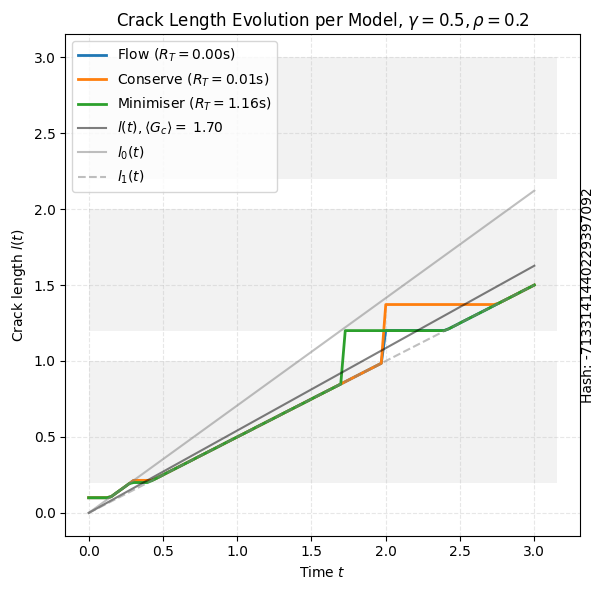

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for label, data in evo_data.items():
    ax.plot(
        data["t_grid"],
        data["l_path"],
        label=f"{label} ($R_T={data['runtime']:.2f}$s)",
        lw=2,
    )
u.add_toughness_background(
    ax,
    x_max=max(data["t_grid"]),
    G0=param_set["G0"],
    G1=param_set["G1"],
    L0=param_set["L0"],
    L1=param_set["L1"],
    alpha=0.05,
    orientation="horizontal",
)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Crack length $l(t)$")

ax.set_title(
    f"Crack Length Evolution per Model, $\\gamma = {_gamma:.1f}, \\rho = {_rho:.1f}$"
)

_hash = hash(f"{param_set['G0']}_{param_set['G1']}_{param_set['L0']}_{param_set['L1']}")
ax.grid(True, linestyle="--", alpha=0.3)

fig.tight_layout()
fig.show()
t_grid = data["t_grid"]

G_avg = (params["G0"] * params["L0"] + params["G1"] * params["L1"]) / (
    params["L0"] + params["L1"]
)

ax.plot(
    t_grid,
    [np.sqrt(-N_val / (2 * G_avg)) * t for t in t_grid],
    color="k",
    linestyle="-",
    label=f"$l(t), \\langle G_c \\rangle =$ {G_avg:.2f}",
    alpha=0.5,
)

ax.plot(
    t_grid,
    [np.sqrt(-N_val / (2 * data["params"]["G0"])) * t for t in t_grid],
    color="gray",
    linestyle="-",
    label="$l_0(t)$",
    alpha=0.5,
)
# ax[0].set_xlim(0, 7)
ax.plot(
    t_grid,
    [np.sqrt(-N_val / (2 * data["params"]["G1"])) * t for t in t_grid],
    color="gray",
    linestyle="--",
    label="$l_1(t)$",
    alpha=0.5,
)
ax.legend()

fig.tight_layout()
# add hash text annotation on right side vertical

fig.text(
    1.0,
    0.5,
    f"Hash: {_hash}",
    fontsize=10,
    ha="right",
    va="center",
    rotation=90,
    # bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)
fig.savefig(f"crack_length_evolution-{_hash}.pdf", dpi=300)


In [55]:
evo_data.keys()

dict_keys(['Flow', 'Conserve', 'Minimiser'])

Variational Flow
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842
 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842 0.13583842

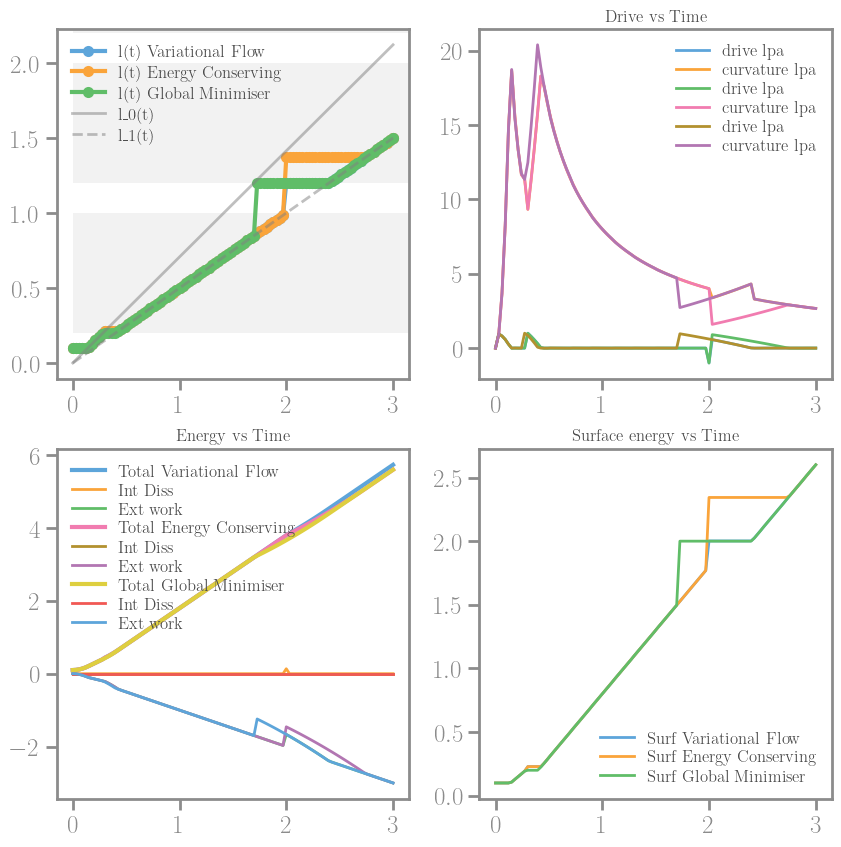

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

evo_variational_flow = evo_data["Flow"]
evo_conserving = evo_data["Conserve"]
evo_global = evo_data['Minimiser']


for evo, label in zip(
    [evo_variational_flow, evo_conserving, evo_global],
    ["Variational Flow", "Energy Conserving", "Global Minimiser"],
):
    print(label)
    l_path = evo["l_path"]
    t_grid = evo["t_grid"]
    E_path = evo["E_path"]

    dissipation_path = evo["dissipation_path"]
    print(dissipation_path)
    drive_path = evo["drive_path"]
    curvature_path = evo["curvature_path"]
    ext_work = N_val * t_grid**2 / (2 * l_path)

    ax[0].plot(t_grid, l_path, label=f"l(t) {label}", lw=3, marker="o")

    ax[1].plot(t_grid, drive_path, label="drive lpa", marker="x")
    ax[1].plot(t_grid, curvature_path, label="curvature lpa", marker="x")
    ax[1].set_title("Drive vs Time")
    ax[1].legend()

    ax[2].plot(t_grid, (E_path + dissipation_path), label=f"Total {label}", lw=3)
    ax[2].plot(t_grid, np.diff(dissipation_path, prepend=0), label="Int Diss")
    ax[2].plot(t_grid, ext_work, label="Ext work")
    # ax[2].plot(t_grid, compute_surface_energy(l_path), label="Surf")
    ax[2].set_title("Energy vs Time")

    ax[3].plot(t_grid, compute_surface_energy(l_path), label=f"Surf {label}")
    ax[3].set_title("Surface energy vs Time")


ax[0].plot(
    t_grid,
    [np.sqrt(-N_val / (2 * G0_val)) * t for t in t_grid],
    color="gray",
    linestyle="-",
    label="l_0(t)",
    alpha=0.5,
)
# ax[0].set_xlim(0, 7)
ax[0].plot(
    t_grid,
    [np.sqrt(-N_val / (2 * G1_val)) * t for t in t_grid],
    color="gray",
    linestyle="--",
    label="l_1(t)",
    alpha=0.5,
)
[_ax.legend() for _ax in ax]
u.add_toughness_background(
    ax[0],
    x_max=max(t_grid),
    G0=G0_val,
    G1=G1_val,
    L0=L0_val,
    L1=L1_val,
    alpha=0.05,
    orientation="horizontal",
)


In [57]:
evo_variational_flow

{'l_path': array([0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.10713739, 0.12856487, 0.14999235, 0.17141983, 0.1928473 ,
        0.21427478, 0.21427478, 0.21427478, 0.21427478, 0.21427478,
        0.22727273, 0.24242424, 0.25757576, 0.27272727, 0.28787879,
        0.3030303 , 0.31818182, 0.33333333, 0.34848485, 0.36363636,
        0.37878788, 0.39393939, 0.40909091, 0.42424242, 0.43939394,
        0.45454545, 0.46969697, 0.48484848, 0.5       , 0.51515152,
        0.53030303, 0.54545455, 0.56060606, 0.57575758, 0.59090909,
        0.60606061, 0.62121212, 0.63636364, 0.65151515, 0.66666667,
        0.68181818, 0.6969697 , 0.71212121, 0.72727273, 0.74242424,
        0.75757576, 0.77272727, 0.78787879, 0.8030303 , 0.81818182,
        0.83333333, 0.84848485, 0.86363636, 0.87878788, 0.89393939,
        0.90909091, 0.92424242, 0.93939394, 0.95454545, 0.96969697,
        0.98484848, 1.20086745, 1.20086745, 1.20086745, 1.20086745,
        1.20086745, 1.20086745, 1.2008

In [ ]:


l_path_conseravation = evo_data["Conserve"]["l_path"]
l_path_flow = evo_data["Flow"]["l_path"]
l_path_global = evo_data["Minimiser"]["l_path"]
l_vals = np.linspace(0.1, max(l_path_flow), 300)

slider = widgets.IntSlider(value=0, min=0, max=99, step=1, description="Step")
play = widgets.Play(
    interval=200, value=0, min=0, max=99, step=1, description="Press play"
)

widgets.jslink((play, "value"), (slider, "value"))


@interact(
    t=widgets.FloatSlider(
        value=1.0,
        min=min(t_grid),
        max=max(t_grid),
        step=t_grid[1] - t_grid[0],
        description="Load t",
    )
    # t=widgets.FloatSlider(value=1.0, min=0.1, max=7.0, step=0.1, description="Load t")
)
def update_plot(t):
    E_vals = compute_energy(l_vals, t_val=t)
    l_minus = np.sqrt(-N_val * t**2 / (2 * np.max([G0_val, G1_val])))
    dE_dl = compute_energy_derivative(l_vals, side="right")
    l_t = l_vs_t(l_path_flow, t_grid, t)
    l_t_cons = l_vs_t(l_path_conseravation, t_grid, t)
    l_t_glob = l_vs_t(l_path_global, t_grid, t)
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(l_vals, E_vals, label=f"$E(l) at t={t:.1f}$")
    ax[0].set_title("Peeling Energy E(l) vs Crack Length l")
    ax[0].set_xlabel("l")
    ax[0].scatter(
        l_minus, compute_energy(l_minus, t_val=t), color="red", label="$l^-$", s=100
    )
    ax[0].scatter(l_t, compute_energy(l_t, t_val=t), color="k", label="$l_t$", s=70)
    ax[0].scatter(
        l_t_cons, compute_energy(l_t_cons, t_val=t), color="C1", label="$l_c$", s=30
    )
    ax[0].scatter(
        l_t_glob,
        compute_energy(l_t_glob, t_val=t),
        color="C2",
        label="$l_g$",
        s=30,
        marker="s",
    )
    ax[0].set_ylabel("E(l)")
    # ax[0].grid(True)
    ax[0].set_ylim((1 - 0.03) * min(E_vals), (1 + 0.1) * min(E_vals))
    ax[0].axhline(min(E_vals), color="gray", linestyle="-", label="min $E$")
    ticks = [min(E_vals), int(min(E_vals) + 1)]
    tick_labels = [f"min E = {ticks[0]:.1f}", f"{ticks[1]:.0f}"]
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(tick_labels)

    # ax[0].set_ylim(-1, 1)
    ax[0].legend()

    ax[1].plot(l_vals, dE_dl, label="$E'(l^-)$", linestyle="-")
    ax[1].scatter(
        l_minus,
        compute_energy_derivative(l_minus, side="right"),
        color="red",
        s=100,
        label="$l^-$",
    )
    ax[1].scatter(
        l_t_cons,
        compute_energy_derivative(l_t_cons, side="right"),
        color="C1",
        label="$l_t$",
        s=30,
    )
    ax[1].scatter(
        l_t,
        compute_energy_derivative(l_t, side="right"),
        color="k",
        label="$l_t$",
        s=30,
    )
    ax[1].scatter(
        l_t_glob,
        compute_energy_derivative(l_t_glob, side="right"),
        color="C2",
        label="$l_g$",
        s=30,
        marker="s",
    )
    ax[1].set_title("(Right) Derivative $E'(l)$ for Binary Periodic Toughness")
    ax[1].set_ylim(-0, 3)

    for _ax in ax:
        u.add_toughness_background(
            _ax,
            x_max=max(l_path_flow),
            G0=G0_val,
            G1=G1_val,
            L0=L0_val,
            L1=L1_val,
            orientation="vertical",
            alpha=0.05,
        )

    plt.tight_layout()
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='Load t', max=3.0, step=0.030303030303030304), Output…

In [59]:
step = widgets.IntText(value=0, description="Step")
next_btn = widgets.Button(description="Next")
prev_btn = widgets.Button(description="Previous")


def on_next(b):
    step.value += 1


def on_prev(b):
    step.value = max(0, step.value - 1)


next_btn.on_click(on_next)
prev_btn.on_click(on_prev)


def update(step):
    print(f"Showing step {step}")  # Replace with plot update


widgets.interactive_output(update, {"step": step})
display(widgets.HBox([prev_btn, next_btn, step]))


In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# === Setup slider + play widget ===
slider = widgets.IntSlider(
    value=0, min=0, max=len(t_grid) - 1, step=1, description="Step"
)
play = widgets.Play(
    interval=200, value=0, min=0, max=len(t_grid) - 1, step=1, description="Play"
)

# Step buttons
step_back = widgets.Button(description="◀ Step Back")
step_fwd = widgets.Button(description="Step Fwd ▶")


# Update slider on button click
def on_step_back(b):
    if slider.value > slider.min:
        slider.value -= 1


def on_step_fwd(b):
    if slider.value < slider.max:
        slider.value += 1


step_back.on_click(on_step_back)
step_fwd.on_click(on_step_fwd)

widgets.jslink((play, "value"), (slider, "value"))

# === Interactive plot using the step index ===
@widgets.interact(idx=slider)
def update_plot(idx):
    t = t_grid[idx]
    E_vals = compute_energy(l_vals, t_val=t)
    # l_minus = np.sqrt(-N_val * t**2 / (2 * np.max([G0_val, G1_val])))
    dE_dl = compute_energy_derivative(l_vals, side="right")
    l_t = l_vs_t(l_path_flow, t_grid, t)
    l_t_cons = l_vs_t(l_path_conseravation, t_grid, t)
    l_t_glob = l_vs_t(l_path_global, t_grid, t)

    fig, ax = plt.subplots(1, 2, figsize=(10, 8))

    # Plot energy
    ax[0].plot(l_vals, E_vals, label=f"$E(l)$ at $t={t:.1f}$", lw=2)
    # ax[0].scatter(
        # l_minus, compute_energy(l_minus, t_val=t), color="red", label="$l^-$", s=100
    # )
    ax[0].scatter(l_t, compute_energy(l_t, t_val=t), color="k", label="$l_t$", s=200)
    ax[0].scatter(
        l_t_cons, compute_energy(l_t_cons, t_val=t), color="C1", label="$l_c$", s=100
    )
    ax[0].scatter(
        l_t_glob,
        compute_energy(l_t_glob, t_val=t),
        color="C2",
        label="$l_g$",
        s=100,
        marker="s",
    )
    ax[0].set_title("Peeling Energy $E(l)$ vs $l$")
    ax[0].set_xlabel("Crack length $l$")
    ax[0].set_ylabel("$E(l)$")
    ax[0].axhline(min(E_vals), color="gray", linestyle="--", label="min $E$")
    ax[0].legend()
    # ax[0].set_ylim((1 - 0.03) * min(E_vals), (1 + 0.3) * min(E_vals))

    # Plot derivative
    ax[1].plot(l_vals, dE_dl, label="$E'(l^-)$", linestyle="-", lw=2)
    # ax[1].scatter(
    #     l_minus,
    #     compute_energy_derivative(l_minus, side="right"),
    #     color="red",
    #     s=100,
    #     label="$l^-$",
    # )
    ax[1].scatter(
        l_t,
        compute_energy_derivative(l_t, side="right"),
        color="k",
        s=200,
        label="$l_t$",
    )
    ax[1].scatter(
        l_t_cons,
        compute_energy_derivative(l_t_cons, side="right"),
        color="C1",
        s=100,
        label="$l_c$",
    )
    ax[1].scatter(
        l_t_glob,
        compute_energy_derivative(l_t_glob, side="right"),
        color="C2",
        s=100,
        marker="s",
        label="$l_g$",
    )
    ax[1].set_title("Right Derivative $E'(l)$")
    ax[1].set_ylim(-0.1, 3.1)

    for _ax in ax:
        u.add_toughness_background(
            _ax,
            x_max=max(l_path_flow),
            G0=G0_val,
            G1=G1_val,
            L0=L0_val,
            L1=L1_val,
            orientation="vertical",
            alpha=0.05,
        )

    plt.tight_layout()
    plt.show()


# Display controls manually
widgets.HBox([play, slider])
display(widgets.HBox([play, slider, step_back, slider, step_fwd]))

interactive(children=(IntSlider(value=0, description='Step', max=99), Output()), _dom_classes=('widget-interac…